In [1]:
from IPython.display import Image
import os
from scipy import misc
from scipy import ndimage
from scipy.misc import toimage
from scipy import stats
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold 
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import glob
import math


min_max_scaler = preprocessing.MinMaxScaler()


def parse_filename(long_name):
    part = long_name.split('.')
    part = part[1].split('_')
    return part[0]


def load_images_by_filename(pic_list):
    houses = dict()
    for filename in pic_list:
        img = misc.imread(filename)
        if img is not None:
            houses[parse_filename(filename)]=np.array(img)
            #images.append(np.array(img))
    #return images
    return houses

def rmse(predictions,targets):
    return np.sqrt(((predictions - targets)**2).mean())

def percentwithin10(predictions,targets):
    count = 0;
    for i in range(0,len(targets)):
        if math.fabs(predictions.iloc[i] - targets[i]) < 0.10 * targets[i]:
            count+=1;
    return count / len(targets);

def percentwithin10_1(predictions,targets):
    count = 0;
    for i in range(0,len(targets)):
        if math.fabs(predictions[i] - targets[i]) < 0.10 * targets[i]:
            count+=1
    print ('total count ' + str(count)+ ' out of ' + str(len(targets)))
    return count / len(targets);



def parse_filename(long_name):
    part = long_name.split('.')
    part = part[1].split('_')
    return part[0]

def load_images_to_map(pic_list):
    houses = dict()
    for filename in pic_list:
        img = misc.imread(filename)
        if img is not None:
            houses[parse_filename(filename)]=np.array(img)
            #images.append(np.array(img))
    return houses


def get_median_error(pred, truth):
    vals = []
    for i in range(0,len(pred)):
        err = math.fabs(pred[i] - truth[i])
        percent = err / truth[i]
        vals.append(percent)
    return np.median(vals)


Using TensorFlow backend.
D:\Anaconda3_10\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
D:\Anaconda3_10\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def load_dataframe():
    #load the dataframe

    # read in data about houses...clean data, normalize, and bring in zip code medians
    
    # read in data about houses...clean data, normalize, and bring in zip code medians
    path = "D:/thesis/*.csv"
    allFiles = glob.glob(path)
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
            df = pd.read_csv(file_,index_col=None, header=0)
            list_.append(df)
    frame = pd.concat(list_)

    frame.columns = ['SALE', 'DATE', 'PROP_TYPE', 'ADDRESS', 'CITY', 'STATE',
               'ZIP', 'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'SQ_FEET', 'LOT_SIZE',
               'YEAR_BUILT', 'DAYS', 'DL_SQFT', 'HOA', 'STATUS',
               'TIME1', 'TIME2',
               'URL',
               'SOURCE', 'MLS', 'FAVORITE', 'INTERESTED', 'LATITUDE', 'LONGITUDE']

    df2 = frame[['DATE','DAYS','DL_SQFT','MLS','ZIP','CITY','PRICE','BEDS','BATHS','SQ_FEET','LOT_SIZE','YEAR_BUILT',
                    'HOA','LATITUDE','LONGITUDE']]

    df2 = df2.drop_duplicates() 
    df2 = df2[np.isfinite(df2['PRICE'])]
    df2 = df2[np.isfinite(df2['BEDS'])]
    df2 = df2[np.isfinite(df2['BATHS'])]
    df2 = df2[np.isfinite(df2['YEAR_BUILT'])]
    df2 = df2[np.isfinite(df2['MLS'])]
    df2['HOA'] = df2['HOA'].fillna(0)

    logAge = np.log(2019 - df2.YEAR_BUILT)
    df2['logAge'] = logAge

    df2['LOT_SIZE'] = df2['LOT_SIZE'].fillna(df2['LOT_SIZE'].median())

    df2.loc[df2.ZIP == 46001,'ZIP'] = 46168
    df2.loc[df2.ZIP == 46067,'ZIP'] = 46077
    df2.loc[df2.CITY == 'Noblesville','ZIP'] = 46062

    df_medians = pd.read_csv("D:/thesis/medians/Book3.csv", index_col = None, header = None, names = ['ZIP','b','c','d', 'MEDIAN'])
    del df_medians['b']
    del df_medians['c']
    del df_medians['d']

    df4 = pd.merge(df2, df_medians, on='ZIP', how='left')

    df4 = df4.dropna()
    df4.MLS = df4.MLS.astype('int32')
    df4.MLS = df4.MLS.astype(str)

    #######################################################################
    
    #remove price outliers
    df4 = df4[df4.PRICE <= 800000]
    df4 = df4[df4.PRICE >= 120000]

    
    return df4




def load_image_map():
    picfiles = glob.glob('d:/house_images_2/**/*.jpg', recursive=True)
    h = load_images_to_map(picfiles)
    return h




In [3]:
from sklearn.model_selection import KFold 
kf = KFold(n_splits= 10, shuffle = True)

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()


In [4]:
house_data = load_dataframe()
features= ['MLS','PRICE','BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE','DAYS',
           'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE',  'MEDIAN','logAge']


X = house_data[features]
y = house_data.PRICE

In [6]:
from sklearn.neighbors import NearestNeighbors

In [26]:
# figure out how it works, then use it in run_NN()

nbrs = NearestNeighbors(n_neighbors=6, algorithm='brute').fit(X[['LONGITUDE','LATITUDE']])

In [27]:
distances, indices = nbrs.kneighbors(X[['LONGITUDE','LATITUDE']])

In [64]:
# fix the index problems numpy / pandas
names = list(X.index[indices])


In [7]:
def run_NN(df, X_train):
    # nearest neighbors columns on training data

    #distance_columns = ['SQ_FEET', 'LATITUDE','LONGITUDE','logAge','LOT_SIZE','LATITUDE','LONGITUDE']
    distance_columns = [ 'LATITUDE','LONGITUDE']
    df5 = X_train[distance_columns]
    nn1 = []
    nn2 = []
    nn3 = []
    nn4 = []
    nn5 = []
    
    nbrs = NearestNeighbors(n_neighbors=6, algorithm='brute').fit(X_train[['LONGITUDE','LATITUDE']])
    distances, indices = nbrs.kneighbors(df[['LONGITUDE','LATITUDE']])
    names = list(X_train.index[indices])
    
    
    for i in range(df.shape[0]):
        
        target = names[i]

        nn1.append( X_train.PRICE[target[1]])
        nn2.append( X_train.PRICE[target[2]])
        nn3.append( X_train.PRICE[target[3]])
        nn4.append( X_train.PRICE[target[4]])
        nn5.append( X_train.PRICE[target[5]])

    df['NN1']= nn1
    df['NN2']= nn2
    df['NN3']= nn3
    df['NN4']= nn4
    df['NN5']= nn5
    
    
    return df


In [8]:
X_NN = run_NN(X, X)

D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
X_NN.head()

,MLS,PRICE,BEDS,BATHS,SQ_FEET,LOT_SIZE,DAYS,YEAR_BUILT,HOA,LATITUDE,LONGITUDE,MEDIAN,logAge,NN1,NN2,NN3,NN4,NN5
0,21507042,295000.0,5.0,3.0,3892.0,14374.0,167.0,1994.0,35.0,40.004712,-86.161206,317906.0,3.218876,364000.0,348000.0,325500.0,350000.0,290000.0
1,21504853,346500.0,4.0,2.5,3923.0,16117.0,139.0,1990.0,29.0,39.972871,-86.165201,317906.0,3.367296,377000.0,752000.0,649990.0,766500.0,269000.0
3,21512685,400000.0,4.0,4.0,5124.0,18295.0,127.0,1996.0,50.0,39.936647,-86.228057,317906.0,3.135494,440000.0,370000.0,320000.0,327900.0,330000.0
4,21517865,501555.0,5.0,5.0,7732.0,26136.0,125.0,2000.0,50.0,39.938926,-86.219860,317906.0,2.944439,528000.0,440000.0,645000.0,289900.0,370000.0
5,21511272,484000.0,3.0,3.5,5462.0,69696.0,135.0,1983.0,19.0,39.932524,-86.171818,317906.0,3.583519,375000.0,389000.0,352500.0,419000.0,795000.0


In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

features2= [ 'BEDS','BATHS', 'SQ_FEET', 'LOT_SIZE',
            'HOA','MEDIAN','logAge']

features3= [ 'BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE',
            'HOA','MEDIAN','logAge', 'NN1','NN2','NN3','NN4','NN5']

features4= ['BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE','DAYS',
           'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE',  'MEDIAN','logAge']

features5= ['BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE','DAYS',
           'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE',  'MEDIAN','logAge',
            'NN1','NN2','NN3','NN4','NN5']

In [32]:


#features2= [ 'BATHS', 'SQ_FEET', 'LOT_SIZE','BEDS',
#           'YEAR_BUILT','YEAR_BUILT_2','HOA',   'MEDIAN', 'HasHOA','LONGITUDE','LATITUDE']

sum_acc = 0
sum_r2 = 0
sum_mae = 0
sum_mer = 0
for train_index, test_index in kf.split(X):
    
    #get splits of pandas dataframes
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

    X_trained = X_train
    X_tested = X_test
    
    #run nearest neighbors
    #X_trained = run_NN(X_train, X_train)
    #X_tested = run_NN(X_test, X_train)
    
    #normalize NN
    #X_trained, X_tested = normalize_NN(X_trained,X_tested)
    
    transformer = min_max_scaler.fit(X_trained)
    X_trained = pd.DataFrame(transformer.transform(X_trained), index=X_trained.index, columns=X_trained.columns)
    X_tested = pd.DataFrame(transformer.transform(X_tested), index=X_tested.index, columns=X_tested.columns)

    #X_trained = X_trained[features2]
    #X_tested = X_tested[features2]
    
    #print(X_trained.head())
    #print(X_tested.head())
    
    #change to numpy arrays - watch the -ed for non NN
    X_trained = X_trained[features4].values
    X_tested = X_tested[features4].values
    y_trained = y_train.values
    y_tested = y_test.values
    
    #rf = GradientBoostingRegressor(loss = 'ls', n_estimators = 100  )
    #rf.fit (X_trained,y_trained )
    
    #rf = RandomForestRegressor(n_estimators = 100)
    #rf.fit (X_trained,y_trained )
    
    #rf = build_model(features4)
    #model_trained = rf.fit(X_trained, y_trained, epochs=300, verbose = 0,
                          validation_data=(X_tested, y_tested))

    rf = best
    rf.fit(X_trained, y_trained )
    #rf = Ridge(alpha=10)
    #rf.fit(X_trained, y_trained ) 
    
    #rf = sm.OLS(y, X).fit()
    #rf = linear_model.LinearRegression()
    #rf.fit (X_trained,y_trained )
    
  
    preds = rf.predict(X_tested)

    mer = get_median_error(preds, y_tested)
    r2 = r2_score(y_tested, preds)
    mae = mean_absolute_error(y_tested, preds)
    perc10 = percentwithin10_1(y_tested, preds)
    
    print("r squared      : " + str(r2))
    print("accuracy validation: " + str(perc10))
    #print("mae validation: " + str(mae))
    print("median error: " + str(mer))
    
    sum_acc += perc10
    sum_r2 += r2
    sum_mae += mae
    sum_mer += mer
    
    print('------------------')

print("average acc: " + str(sum_acc/10))
#print("average mae: " + str(sum_mae/10))
print("average mer: " + str(sum_mer/10))
print("average r2: " + str(sum_r2/10))

total count 263 out of 542
r squared      : 0.8491639350734248
accuracy validation: 0.48523985239852396
median error: 0.09931970107132895
------------------
total count 271 out of 542
r squared      : 0.8180847275088918
accuracy validation: 0.5
median error: 0.10090133423908426
------------------
total count 274 out of 542
r squared      : 0.8489067384123823
accuracy validation: 0.5055350553505535
median error: 0.09573146288306172
------------------
total count 270 out of 542
r squared      : 0.8031892787244582
accuracy validation: 0.4981549815498155
median error: 0.10121642268264713
------------------
total count 256 out of 542
r squared      : 0.7600968768053815
accuracy validation: 0.47232472324723246
median error: 0.1058302394701087
------------------
total count 248 out of 542
r squared      : 0.7944982017395501
accuracy validation: 0.4575645756457565
median error: 0.1049397085063932
------------------
total count 241 out of 542
r squared      : 0.811758538592036
accuracy validati

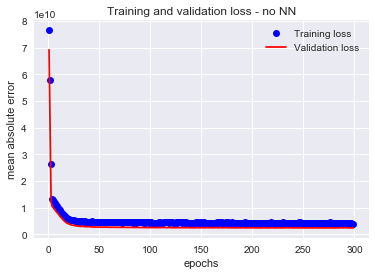

In [35]:
loss = model_trained.history['loss']
val_loss = model_trained.history['val_loss']
epoch = range(300)
plt.figure()
plt.plot(epoch[1:], loss[1:], 'bo', label='Training loss')
#plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch[1:], val_loss[1:], 'r', label='Validation loss')
plt.title('Training and validation loss - no NN')
plt.xlabel('epochs')
plt.ylabel('mean absolute error')
plt.legend()
plt.show()

In [44]:


#features2= [ 'BATHS', 'SQ_FEET', 'LOT_SIZE','BEDS',
#           'YEAR_BUILT','YEAR_BUILT_2','HOA',   'MEDIAN', 'HasHOA','LONGITUDE','LATITUDE']

sum_acc = 0
sum_r2 = 0
sum_mae = 0
sum_mer = 0
for train_index, test_index in kf.split(X_NN):
    
    #get splits of pandas dataframes
    X_train, X_test = X_NN.iloc[train_index], X_NN.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

    X_trained = X_train
    X_tested = X_test
    
    #run nearest neighbors
    X_trained = run_NN(X_train, X_train)
    X_tested = run_NN(X_test, X_train)
    
    #normalize NN
    #X_trained, X_tested = normalize_NN(X_trained,X_tested)
    
    transformer = min_max_scaler.fit(X_trained)
    X_trained = pd.DataFrame(transformer.transform(X_trained), index=X_trained.index, columns=X_trained.columns)
    X_tested = pd.DataFrame(transformer.transform(X_tested), index=X_tested.index, columns=X_tested.columns)

    #X_trained = X_trained[features2]
    #X_tested = X_tested[features2]
    
    #print(X_trained.head())
    #print(X_tested.head())
    
    #change to numpy arrays - watch the -ed for non NN
    X_trained = X_trained[features5].values
    X_tested = X_tested[features5].values
    y_trained = y_train.values
    y_tested = y_test.values
    
    #rf = GradientBoostingRegressor(loss = 'ls', n_estimators = 100  )
    #rf.fit (X_trained,y_trained )
    
    #rf = RandomForestRegressor(n_estimators = 100)
    #rf.fit (X_trained,y_trained )

    rf = best
    rf.fit(X_trained, y_trained )
    
    #rf = build_model(features5)
    #model_trained = rf.fit(X_trained, y_trained, epochs=200, verbose = 1,
    #                      validation_data=(X_tested, y_tested))

    #rf = Ridge(alpha=10)
    #rf.fit(X_trained, y_trained ) 
    
    #rf = sm.OLS(y, X).fit()
    #rf = linear_model.LinearRegression()
    #rf.fit (X_trained,y_trained )
    
  
    preds = rf.predict(X_tested)

    mer = get_median_error(preds, y_tested)
    r2 = r2_score(y_tested, preds)
    mae = mean_absolute_error(y_tested, preds)
    perc10 = percentwithin10_1(y_tested, preds)
    
    print("r squared      : " + str(r2))
    print("accuracy validation: " + str(perc10))
    #print("mae validation: " + str(mae))
    print("median error: " + str(mer))
    
    sum_acc += perc10
    sum_r2 += r2
    sum_mae += mae
    sum_mer += mer
    
    print('------------------')

print("average acc: " + str(sum_acc/10))
#print("average mae: " + str(sum_mae/10))
print("average mer: " + str(sum_mer/10))
print("average r2: " + str(sum_r2/10))

D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anac

total count 361 out of 542
r squared      : 0.883718027845245
accuracy validation: 0.6660516605166051
median error: 0.06992728733773967
------------------
total count 341 out of 542
r squared      : 0.8974943688554968
accuracy validation: 0.6291512915129152
median error: 0.06937324442854534
------------------
total count 375 out of 542
r squared      : 0.8627596869622263
accuracy validation: 0.6918819188191881
median error: 0.0617773906636001
------------------
total count 358 out of 542
r squared      : 0.8953071053149668
accuracy validation: 0.6605166051660517
median error: 0.07110190726243708
------------------
total count 351 out of 542
r squared      : 0.9004857951019506
accuracy validation: 0.6476014760147601
median error: 0.06889131887342925
------------------
total count 372 out of 542
r squared      : 0.8563045975362613
accuracy validation: 0.6863468634686347
median error: 0.06473722499529892
------------------
total count 361 out of 542
r squared      : 0.8851920948464642
acc

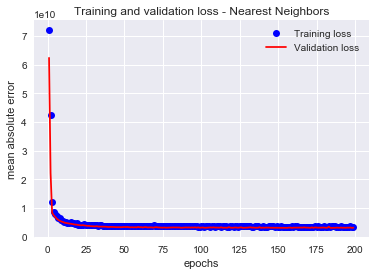

In [31]:
loss = model_trained.history['loss']
val_loss = model_trained.history['val_loss']
epoch = range(200)
plt.figure()
plt.plot(epoch[1:], loss[1:], 'bo', label='Training loss')
#plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch[1:], val_loss[1:], 'r', label='Validation loss')
plt.title('Training and validation loss - Nearest Neighbors')
plt.xlabel('epochs')
plt.ylabel('mean absolute error')
plt.legend()
plt.show()

In [12]:
def build_model(features):
    model = Sequential()
    model.add(Dense(96, activation = 'relu', input_shape=(len(features),)))
    model.add(Dropout(.45))
    model.add(Dense(96, activation = 'relu'))
    model.add(Dropout(.45))
    model.add(Dense(64, activation = 'relu'))

 
    #model.add(Dropout(.2))
    model.add(Dense(1))
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    #model.compile(optimizer = adam, loss = 'mse', metrics = ['mae'])
    return model

In [38]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
# optimize random forest model

In [36]:
n_estimators = [ 1000,2000]
max_features = ['auto']
max_depth = [10, 20]
min_samples_split = [  5,10]
min_samples_leaf = [ 4,8 ]
bootstrap = [True]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [39]:
rf = RandomForestRegressor()
rf_random = GridSearchCV(rf, 
                               random_grid, 
                               cv = 3, 
                               verbose=1,  n_jobs = -1)

In [45]:
rf_random.fit(X[features4], y)
print(rf_random.best_params_)
best = rf_random.best_estimator_

Fitting 6 folds for each of 2 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   11.7s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   12.5s finished


{'max_depth': 8, 'max_features': 0.3, 'n_estimators': 1000, 'learning_rate': 0.01, 'min_samples_leaf': 30}


In [ ]:
# optimize gradient boosting model

In [41]:
gb_grid_params = {'learning_rate': [0.01],
              'max_depth': [ 8],
              'min_samples_leaf': [30],
              'max_features': [ 0.3,0.5 ],
              'n_estimators' : [ 1000] 
              }

rf = GradientBoostingRegressor(loss = 'ls')
rf_random = GridSearchCV(rf, 
                               gb_grid_params, 
                               cv = 6, 
                               verbose=1, n_jobs = -1)

In [42]:
rf_random.fit(X[features4], y)
print(rf_random.best_params_)
best = rf_random.best_estimator_

Fitting 6 folds for each of 2 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   11.6s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   12.5s finished


{'max_depth': 8, 'max_features': 0.3, 'n_estimators': 1000, 'learning_rate': 0.01, 'min_samples_leaf': 30}
